In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchsummary

In [ ]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 4.8 MB/s 


#### Se carga el dataset CIFAR10 y se visualizan algunas imágenes

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
### Descripción del conjunto de entrenamiento ###
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(32, 32, 3)
### Descripción del conjunto de evaluación ###
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: 6
Label de la imágen 1: 9
Label de la imágen 2: 9
Label de la imágen 3: 4
Label de la imágen 4: 1
Label de la imágen 5: 1
Label de la imágen 6: 2
Label de la imágen 7: 7
Label de la imágen 8: 8


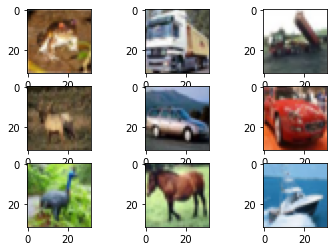

In [ ]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_set)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image, cmap=plt.get_cmap())
  print("Label de la imágen {}: {}".format(i, label))

plt.show()

#### Transformación y separación en train y validación

In [ ]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
valid_set_size = 5000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


#### Dataloader (batch de 32)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)

#### Implemeantación de la red convolucional (ConvNet)

*   Conv1: cantidad de filtros=16, tramaño de filtro=3, stride=1, padding="same"
*   Pool1: MaxPooling, tamaño de filtro=2, stride=2
*   Conv2: cantidad de filtros=32, tramaño de filtro=3, stride=1, padding="same"
*   Pool2: MaxPooling, tamaño de filtro=2, stride=2
*   Conv3: cantidad de filtros=64, tramaño de filtro=3, stride=1, padding="same"
*   Pool3: MaxPooling, tamaño de filtro=2, stride=2
*   Conv4: cantidad de filtros=128, tramaño de filtro=3, stride=1, padding="same"
*   Linear1: cantidad de neuronas=100
*   Linear2: capa de salida

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.fc1 = torch.nn.Linear(in_features=4*4*128, out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.tanh(self.conv1(x)))
        x = self.pool2(torch.tanh(self.conv2(x)))
        x = self.pool3(torch.tanh(self.conv3(x)))
        x = torch.tanh(self.conv4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

convnet_model = ConvNet()

In [ ]:
torchsummary.summary(convnet_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
            Linear-8                  [-1, 100]         204,900
            Linear-9                   [-1, 10]           1,010
Total params: 303,350
Trainable params: 303,350
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 1.16
Estimated Total Size (MB): 1.46
-------------------------------------------

#### Defino optimizador, función de pérdida y métricas

In [ ]:
convnet_optimizer = torch.optim.SGD(convnet_model.parameters(), lr=0.01)

convnet_loss = torch.nn.CrossEntropyLoss()

convnet_accuracy = torchmetrics.Accuracy()

#### Entreno por 30 epochs

In [ ]:
# Epocas de entrenamiento
epochs = 30

dataiter = iter(train_loader)
images, labels = dataiter.next()


# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Seteo los gradientes en cero ya que, por defecto, PyTorch
    # los va acumulando
    convnet_optimizer.zero_grad()

    # Realizo el forward pass de nuestro modelo
    output = convnet_model(train_data)

    # Computo el error de la salida comparando contra las etiquetas
    loss = convnet_loss(output, train_target)

    # Almaceno el error del batch para luego tener el error promedio de la epoca
    epoch_train_loss += loss.item()

    # Computo el nuevo set de gradientes a lo largo de toda la red
    loss.backward()

    # Realizo el paso de optimizacion actualizando los parametros de toda la red
    convnet_optimizer.step()

    # Calculo el accuracy del batch
    accuracy = convnet_accuracy(output, train_target)

    # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  valid_data, valid_target = iter(valid_loader).next()
  output = convnet_model(valid_data)
  epoch_valid_loss = convnet_loss(output, valid_target).item()
  epoch_valid_accuracy = convnet_accuracy(output, valid_target).item()
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/30 - Train loss 2.184049 - Train Accuracy 0.196695 - Valid Loss 2.016273 - Valid Accuracy 0.260400
Epoch: 2/30 - Train loss 1.902335 - Train Accuracy 0.311034 - Valid Loss 1.796284 - Valid Accuracy 0.350600
Epoch: 3/30 - Train loss 1.660089 - Train Accuracy 0.400897 - Valid Loss 1.605199 - Valid Accuracy 0.436000
Epoch: 4/30 - Train loss 1.502717 - Train Accuracy 0.456490 - Valid Loss 1.545200 - Valid Accuracy 0.458200
Epoch: 5/30 - Train loss 1.404171 - Train Accuracy 0.495491 - Valid Loss 1.350888 - Valid Accuracy 0.509200
Epoch: 6/30 - Train loss 1.329042 - Train Accuracy 0.524720 - Valid Loss 1.305950 - Valid Accuracy 0.533800
Epoch: 7/30 - Train loss 1.259250 - Train Accuracy 0.550751 - Valid Loss 1.257120 - Valid Accuracy 0.552200
Epoch: 8/30 - Train loss 1.194386 - Train Accuracy 0.574916 - Valid Loss 1.624395 - Valid Accuracy 0.454000
Epoch: 9/30 - Train loss 1.132376 - Train Accuracy 0.599236 - Valid Loss 1.187697 - Valid Accuracy 0.578600
Epoch: 10/30 - Train loss 1.

#### Grafico los resultados

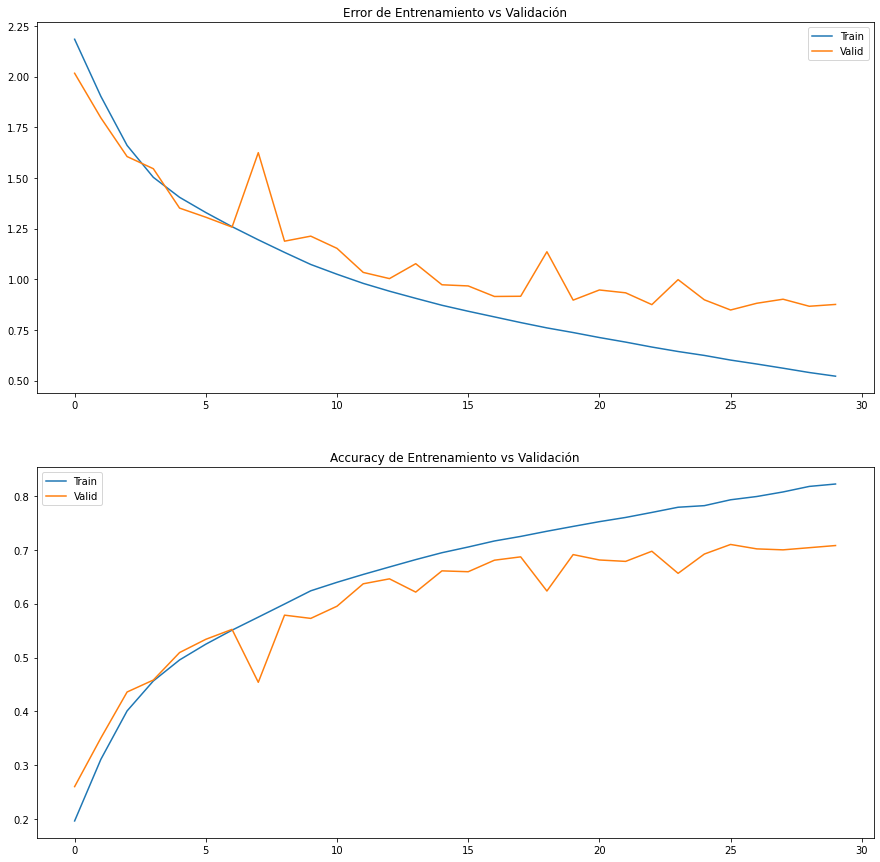

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(train_loss)
axs[0].plot(valid_loss) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [ ]:
# Realizo el paso de evaluación computando error y accuracy

test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = convnet_model(test_data)
  test_loss += convnet_loss(output, test_target).item()
  test_accuracy += convnet_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.870537 y una accuracy de 0.711300


### Data augmentation (horizontal flip, resize, color)

In [ ]:
aud_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(32, 32), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                        torchvision.transforms.ToTensor(),
                      ])

aug_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, transform=aud_data_transforms)
aug_valid_set = torchvision.datasets.CIFAR10(root='./data', train=False, transform=aud_data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=32, shuffle=True)

#### Se mantiene la misma arquitectura de red, optimizador, etc.

In [ ]:
aug_conv_model = ConvNet()

if torch.cuda.is_available():
  aug_conv_model = aug_conv_model.to("cuda")

aug_conv_model_optimizer = torch.optim.SGD(aug_conv_model.parameters(), lr=0.01)

aug_conv_model_loss = torch.nn.CrossEntropyLoss()

aug_conv_model_accuracy = torchmetrics.Accuracy()

#### Entreno por 30 epochs

In [ ]:
if torch.cuda.is_available():
  aug_conv_model_accuracy = aug_conv_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 30

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

In [ ]:
## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for aug_train_data, aug_train_target in aug_train_loader:

    if torch.cuda.is_available():
      aug_train_data = aug_train_data.to("cuda")
      aug_train_target = aug_train_target.to("cuda")

    aug_conv_model_optimizer.zero_grad()
    
    aug_output = aug_conv_model(aug_train_data)
    
    aug_loss = aug_conv_model_loss(aug_output, aug_train_target)
    epoch_train_loss += aug_loss.item()
    aug_loss.backward()
    
    aug_conv_model_optimizer.step()
    accuracy = aug_conv_model_accuracy(aug_output, aug_train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(aug_train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(aug_train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for aug_valid_data, aug_valid_target in aug_valid_loader:
    if torch.cuda.is_available():
      aug_valid_data = aug_valid_data.to("cuda")
      aug_valid_target = aug_valid_target.to("cuda")

    aug_output = aug_conv_model(aug_valid_data)
    epoch_valid_loss += aug_conv_model_loss(aug_output, aug_valid_target).item()
    epoch_valid_accuracy += aug_conv_model_accuracy(aug_output, aug_valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(aug_valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(aug_valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/30 - Train loss 2.191406 - Train Accuracy 0.183241 - Valid Loss 2.058362 - Valid Accuracy 0.246905
Epoch: 2/30 - Train loss 1.928858 - Train Accuracy 0.293886 - Valid Loss 1.865786 - Valid Accuracy 0.326378
Epoch: 3/30 - Train loss 1.748249 - Train Accuracy 0.364763 - Valid Loss 1.683654 - Valid Accuracy 0.382987
Epoch: 4/30 - Train loss 1.628667 - Train Accuracy 0.405810 - Valid Loss 1.588777 - Valid Accuracy 0.417033
Epoch: 5/30 - Train loss 1.564438 - Train Accuracy 0.433301 - Valid Loss 1.545802 - Valid Accuracy 0.436402
Epoch: 6/30 - Train loss 1.515972 - Train Accuracy 0.451336 - Valid Loss 1.482710 - Valid Accuracy 0.458966
Epoch: 7/30 - Train loss 1.471651 - Train Accuracy 0.468390 - Valid Loss 1.456857 - Valid Accuracy 0.467951
Epoch: 8/30 - Train loss 1.424779 - Train Accuracy 0.489843 - Valid Loss 1.428634 - Valid Accuracy 0.489816
Epoch: 9/30 - Train loss 1.374917 - Train Accuracy 0.508077 - Valid Loss 1.383937 - Valid Accuracy 0.497804
Epoch: 10/30 - Train loss 1.

#### Grafico los resultados

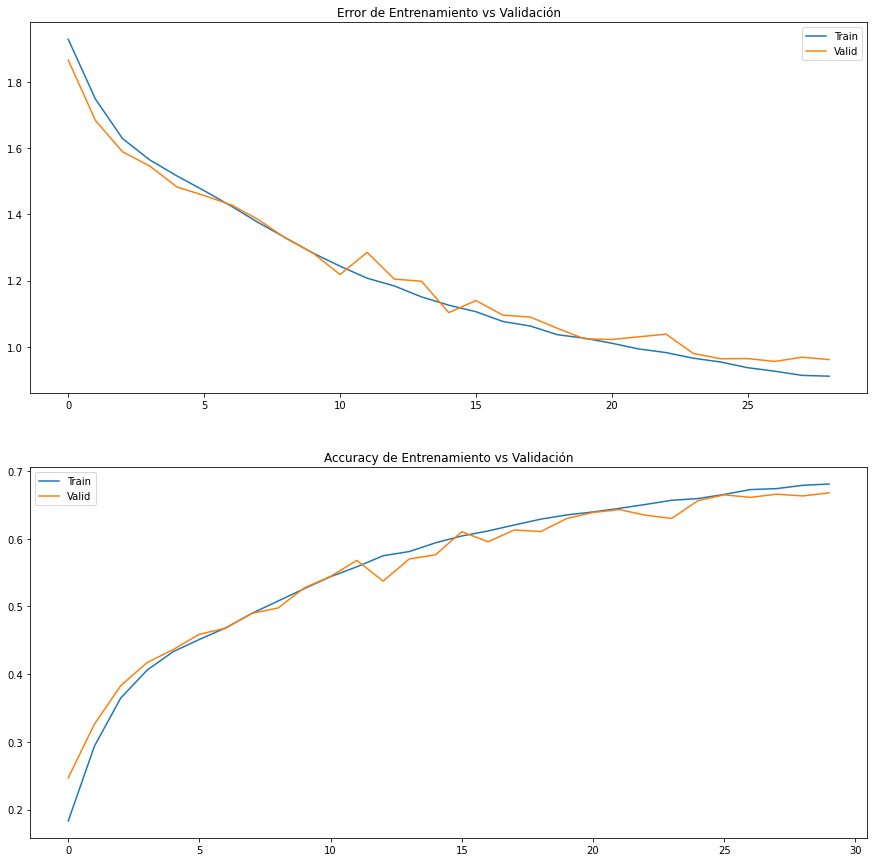

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [ ]:
# Realizo el paso de evaluación computando error y accuracy (sin aplicar data augmentation)

test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
  output = aug_conv_model(test_data)
  test_loss += aug_conv_model_loss(output, test_target).item()
  test_accuracy += aug_conv_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.852055 y una accuracy de 0.704700


#### Resumen

Se implementó la red convolucional con la arquitectura propuesta en clase y se la entrena utilizando el dataset CIFAR10.

Se observa una leve tendencia al sobreajuste del modelo. Esto se debe a que se tiene una cantidad predefinida de datos y la red durante el entrenamiento puede memorizar las etiquetas de los mismos.

Luego se entrena el mismo modelo pero al dataset se le aplica data augmentation.
Se ve que el modelo no sobreajusta pero es un poco más lento (necesita mas epochs). Esto se debe a que se entrena la red con un conjunto de datos de tamaño considerablemente mayor al dataset original y el modelo observa imágenes nuevas cada paso y no puede memorizarlas tan facilmente.